<h1> InputDataSet Class and sktime example </h1>
First we import packages and check we have access to the GPU.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.deep_learning.resnet import ResNetClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.hybrid import HIVECOTEV2


from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-08-19 15:43:14.663644: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 15:43:14.849306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 15:43:14.849459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 15:43:14.877913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 15:43:14.944683: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2024-08-19 15:43:17.026391: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-19 15:43:17.054783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-19 15:43:17.054874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<h2> Define functions </h2>
A function to asses the models we train.

In [2]:
def asses_model(model_name, y_pred, y_test, labels_order):
    print()
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_pred, y_test)

    # Print accuracy and Cohen Kappa score with explanations
    print(f'Accuracy of {model_name}: {accuracy:.4f}')
    print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

    # Calculate the normalized predicted label count
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred)}
    
    # Calculate the percent the model over or under predicted the labels using the specified label order
    sorted_values = [normalized_counts_pred[k] - 1 if k in normalized_counts_pred else 0 for k in labels_order]

    # Plotting the percent the model over or under predicted the labels
    plt.figure(figsize=(2*len(labels_order)+10, 4))
    plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
    plt.title(f'Percent Model {model_name} Over or Under Predicted Labels')
    plt.xlabel('Labels')
    plt.ylabel('Percent Over/Under Prediction')
    
    # Center y-axis and set equal extension above and below
    max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
    plt.ylim(-max_extent, max_extent)
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.show()

    # Display each confusion matrix on its own row
    for norm in [None, 'true', 'pred']:
        plt.figure(figsize=(len(labels_order)+4, len(labels_order)+4))
        ax = plt.gca()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, normalize=norm, ax=ax,
            xticks_rotation='vertical', labels=labels_order
        )
        ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')
        plt.tight_layout()
        plt.show()
    

<h2> Define Features </h2>
Here we define the parameters for the InputDataSet object we will create. It includes the source of the data we want and a list of features we will restrict ourselves to.

In [3]:
# We classify 5 characters on competitive stages

source_data = ['public','ranked','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True]
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    # 'character_name': ['PIKACHU','PICHU'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'], # No ZELDA
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}
    

<h2> Create Dataset Object </h2>
We create the dataset object and check the number of games for each label in our data and print the first several rows of the dataset to make sure it looks correct.

In [4]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())
# print(list(dataset.dataset['labels'].unique()))
# dataset.dataset.head()

/workspace/slp_jaspar/rocket_classifier_all_data/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


<h2> Call number_of_segments_per_game() </h2>
We set the length of the segments and the number of segments per label that we want in the dataset we are going to prepare. In the column 'Count' we see the number of games we have for each label (this is less than the value counts earlier because we discard games that are too short). In the column 'Shift' we see how much each segment will be shifted by. If the shift is less than the length of the segments, the data we prepare will contain overlaping segments.

In [5]:
labels_order =  dataset.number_of_segments_per_game(3600,100)
print(labels_order)
labels_order = labels_order['Label'].values


             Label   Count   Shift
0              FOX  102551  120601
1            FALCO   90263  103954
2            MARTH   53538   68557
3   CAPTAIN_FALCON   37820   43246
4            SHEIK   27536   39604
5            PEACH   17367   27064
6       JIGGLYPUFF   16214   24015
7            SAMUS    9489   16294
8     ICE_CLIMBERS    6820   10776
9        GANONDORF    6611    8103
10           YOSHI    5704    8177
11           LUIGI    5210    7765
12        DR_MARIO    4177    6091
13         PIKACHU    4067    6097
14            LINK    2489    3829
15            NESS    2291    4183
16     DONKEY_KONG    2009    2903
17  GAME_AND_WATCH    1949    2305
18          MEWTWO    1758    3257
19           MARIO    1710    2612
20      YOUNG_LINK    1430    2256
21             ROY    1262    1787
22          BOWSER     934    1532
23           KIRBY     531     851
24           PICHU     227     330


<h2> Split data and prepare it for the model </h2>

In [6]:
X_train, X_test, y_train, y_test  = dataset.train_test_split_numpy(test_ratio = .20, val = False)
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

100%|██████████| 80740/80740 [00:00<00:00, 123121.89it/s]



(100000, 9, 3600)
(100000,)
(25000, 9, 3600)
(25000,)


In [7]:
import sktime.transformations.panel.rocket._minirocket_multi_numba as minirocket

In [9]:
parameters = minirocket._fit_multi(X_train, num_features=128000)
print(parameters)

(array([1, 2, 4, ..., 1, 2, 2], dtype=int32), array([5, 6, 2, ..., 5, 5, 6], dtype=int32), array([  1,   2,   3,   4,   5,   7,   8,  10,  12,  15,  19,  23,  28,
        34,  42,  51,  62,  76,  92, 113, 137, 167, 204, 249, 303, 369,
       449], dtype=int32), array([191,  96,  96,  48,  48,  48,  48,  48,  48,  48,  48,  48,  48,
        48,  48,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,
        47], dtype=int32), array([ 0.,  0.,  0., ..., -1.,  0.,  0.], dtype=float32))


Transformation is 263.16 segments per second.

In [9]:
transformed_train = minirocket._transform_multi(X_train, parameters)

In [15]:
# save_path = "/workspace/melee_project_data/MiniRocket_Transform/"
# import gzip
# with gzip.open(save_path + 'minirocket_all_characters_60s_5000_segments_per_character_train', 'wb') as f:
#     np.save(f, transformed_train)
# transformed_train.to_parquet(save_path + 'minirocket_all_characters_60s_5000_segments_per_character', engine = 'pyarrow', compression='gzip')

In [16]:
# import numpy as np
# import os

# # Define the path and ensure the directory exists
# save_path = "/workspace/melee_project_data/MiniRocket_Transform/"
# filename = 'minirocket_all_characters_60s_5000_segments_per_character_train.dat'
# full_path = os.path.join(save_path, filename)
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# # Create a memory-mapped file
# shape = transformed_train.shape  # assuming 'transformed_train' is a NumPy array
# dtype = transformed_train.dtype
# fp = np.memmap(full_path, dtype=dtype, mode='w+', shape=shape)

# # Copy data to memory-mapped file
# fp[:] = transformed_train[:]

# # Flush changes to ensure all data is written to the file
# fp.flush()

# # When reading back the data, you can map the file to memory like this:
# new_fp = np.memmap(full_path, dtype=dtype, mode='r', shape=shape)


In [10]:
transformed_test = minirocket._transform_multi(X_test, parameters)

In [12]:
# save_path = "/workspace/melee_project_data/MiniRocket_Transform/"
# import gzip
# with gzip.open(save_path + 'minirocket_all_characters_60s_5000_segments_per_character_test', 'wb') as f:
#     np.save(f, transformed_test)
# # transformed_train.to_parquet(save_path + 'minirocket_all_characters_60s_5000_segments_per_character', engine = 'pyarrow', compression='gzip')

In [13]:
# import numpy as np
# import os

# # Define the path and ensure the directory exists
# save_path = "/workspace/melee_project_data/MiniRocket_Transform/"
# filename = 'minirocket_all_characters_60s_5000_segments_per_character_test.dat'
# full_path = os.path.join(save_path, filename)
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# # Create a memory-mapped file
# shape = transformed_test.shape  # assuming 'transformed_train' is a NumPy array
# dtype = transformed_test.dtype
# fp = np.memmap(full_path, dtype=dtype, mode='w+', shape=shape)

# # Copy data to memory-mapped file
# fp[:] = transformed_test[:]

# # Flush changes to ensure all data is written to the file
# fp.flush()

# # When reading back the data, you can map the file to memory like this:
# new_fp = np.memmap(full_path, dtype=dtype, mode='r', shape=shape)


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=1000, verbose=1).fit(transformed_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      3198325     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28755D+05    |proj g|=  4.52665D+02


 This problem is unconstrained.



At iterate   50    f=  6.15800D+04    |proj g|=  8.95700D+01


KeyboardInterrupt: 

In [ ]:
y_pred = clf.predict(transformed_test)

In [ ]:
clf.score(transformed_test, y_test)

0.8874


Accuracy of minirocket: 0.8998
Cohen Kappa Score of minirocket: 0.8956


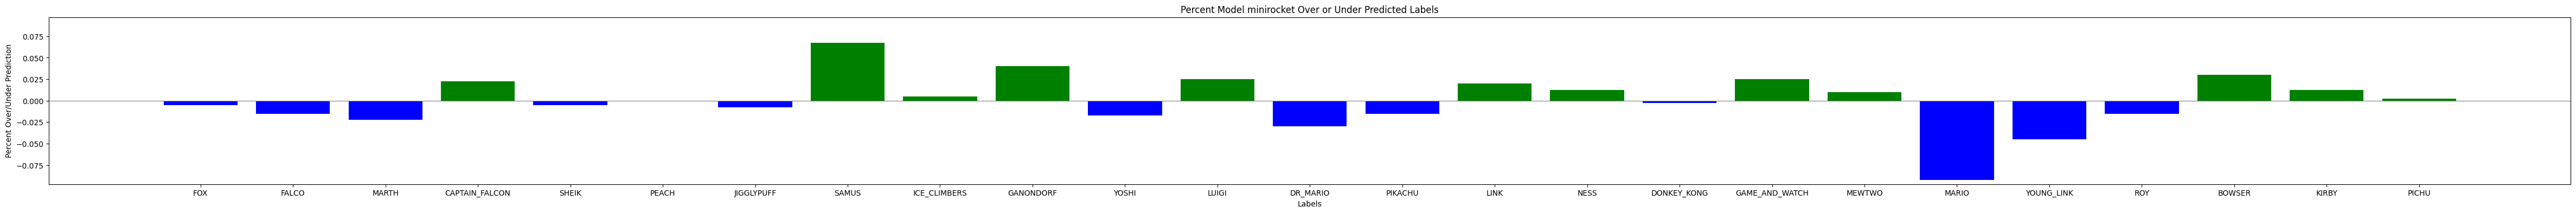

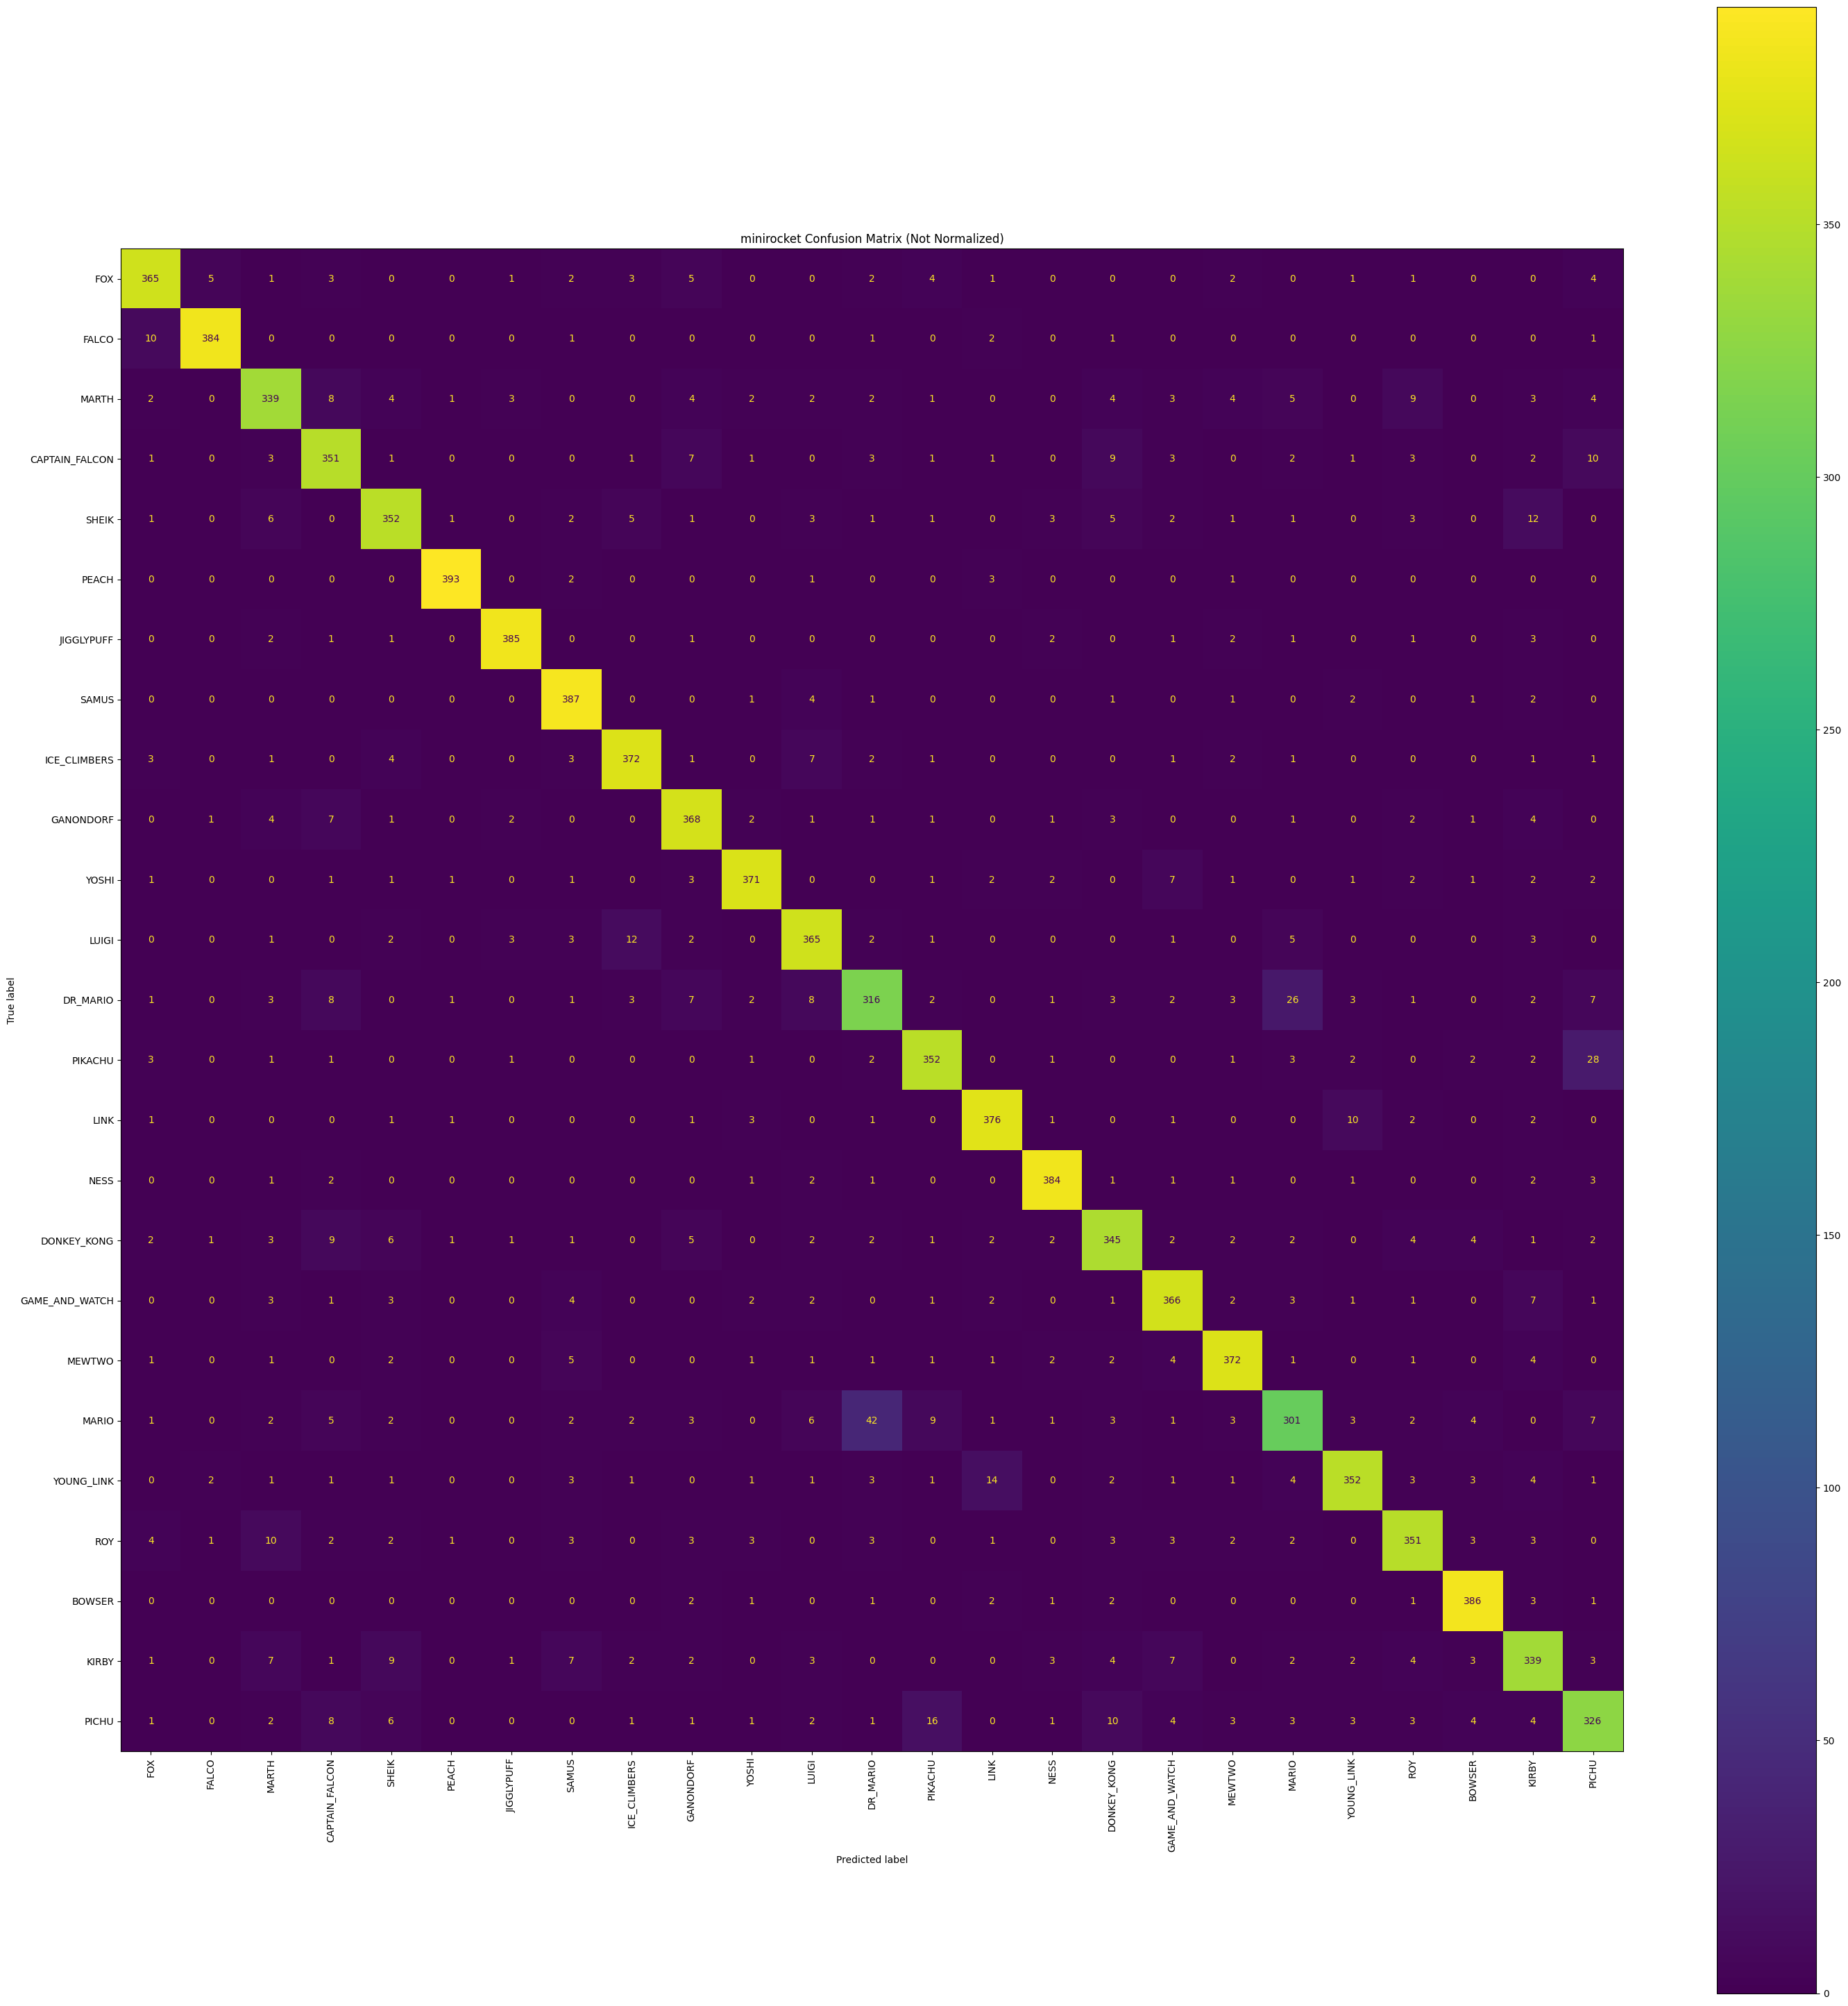

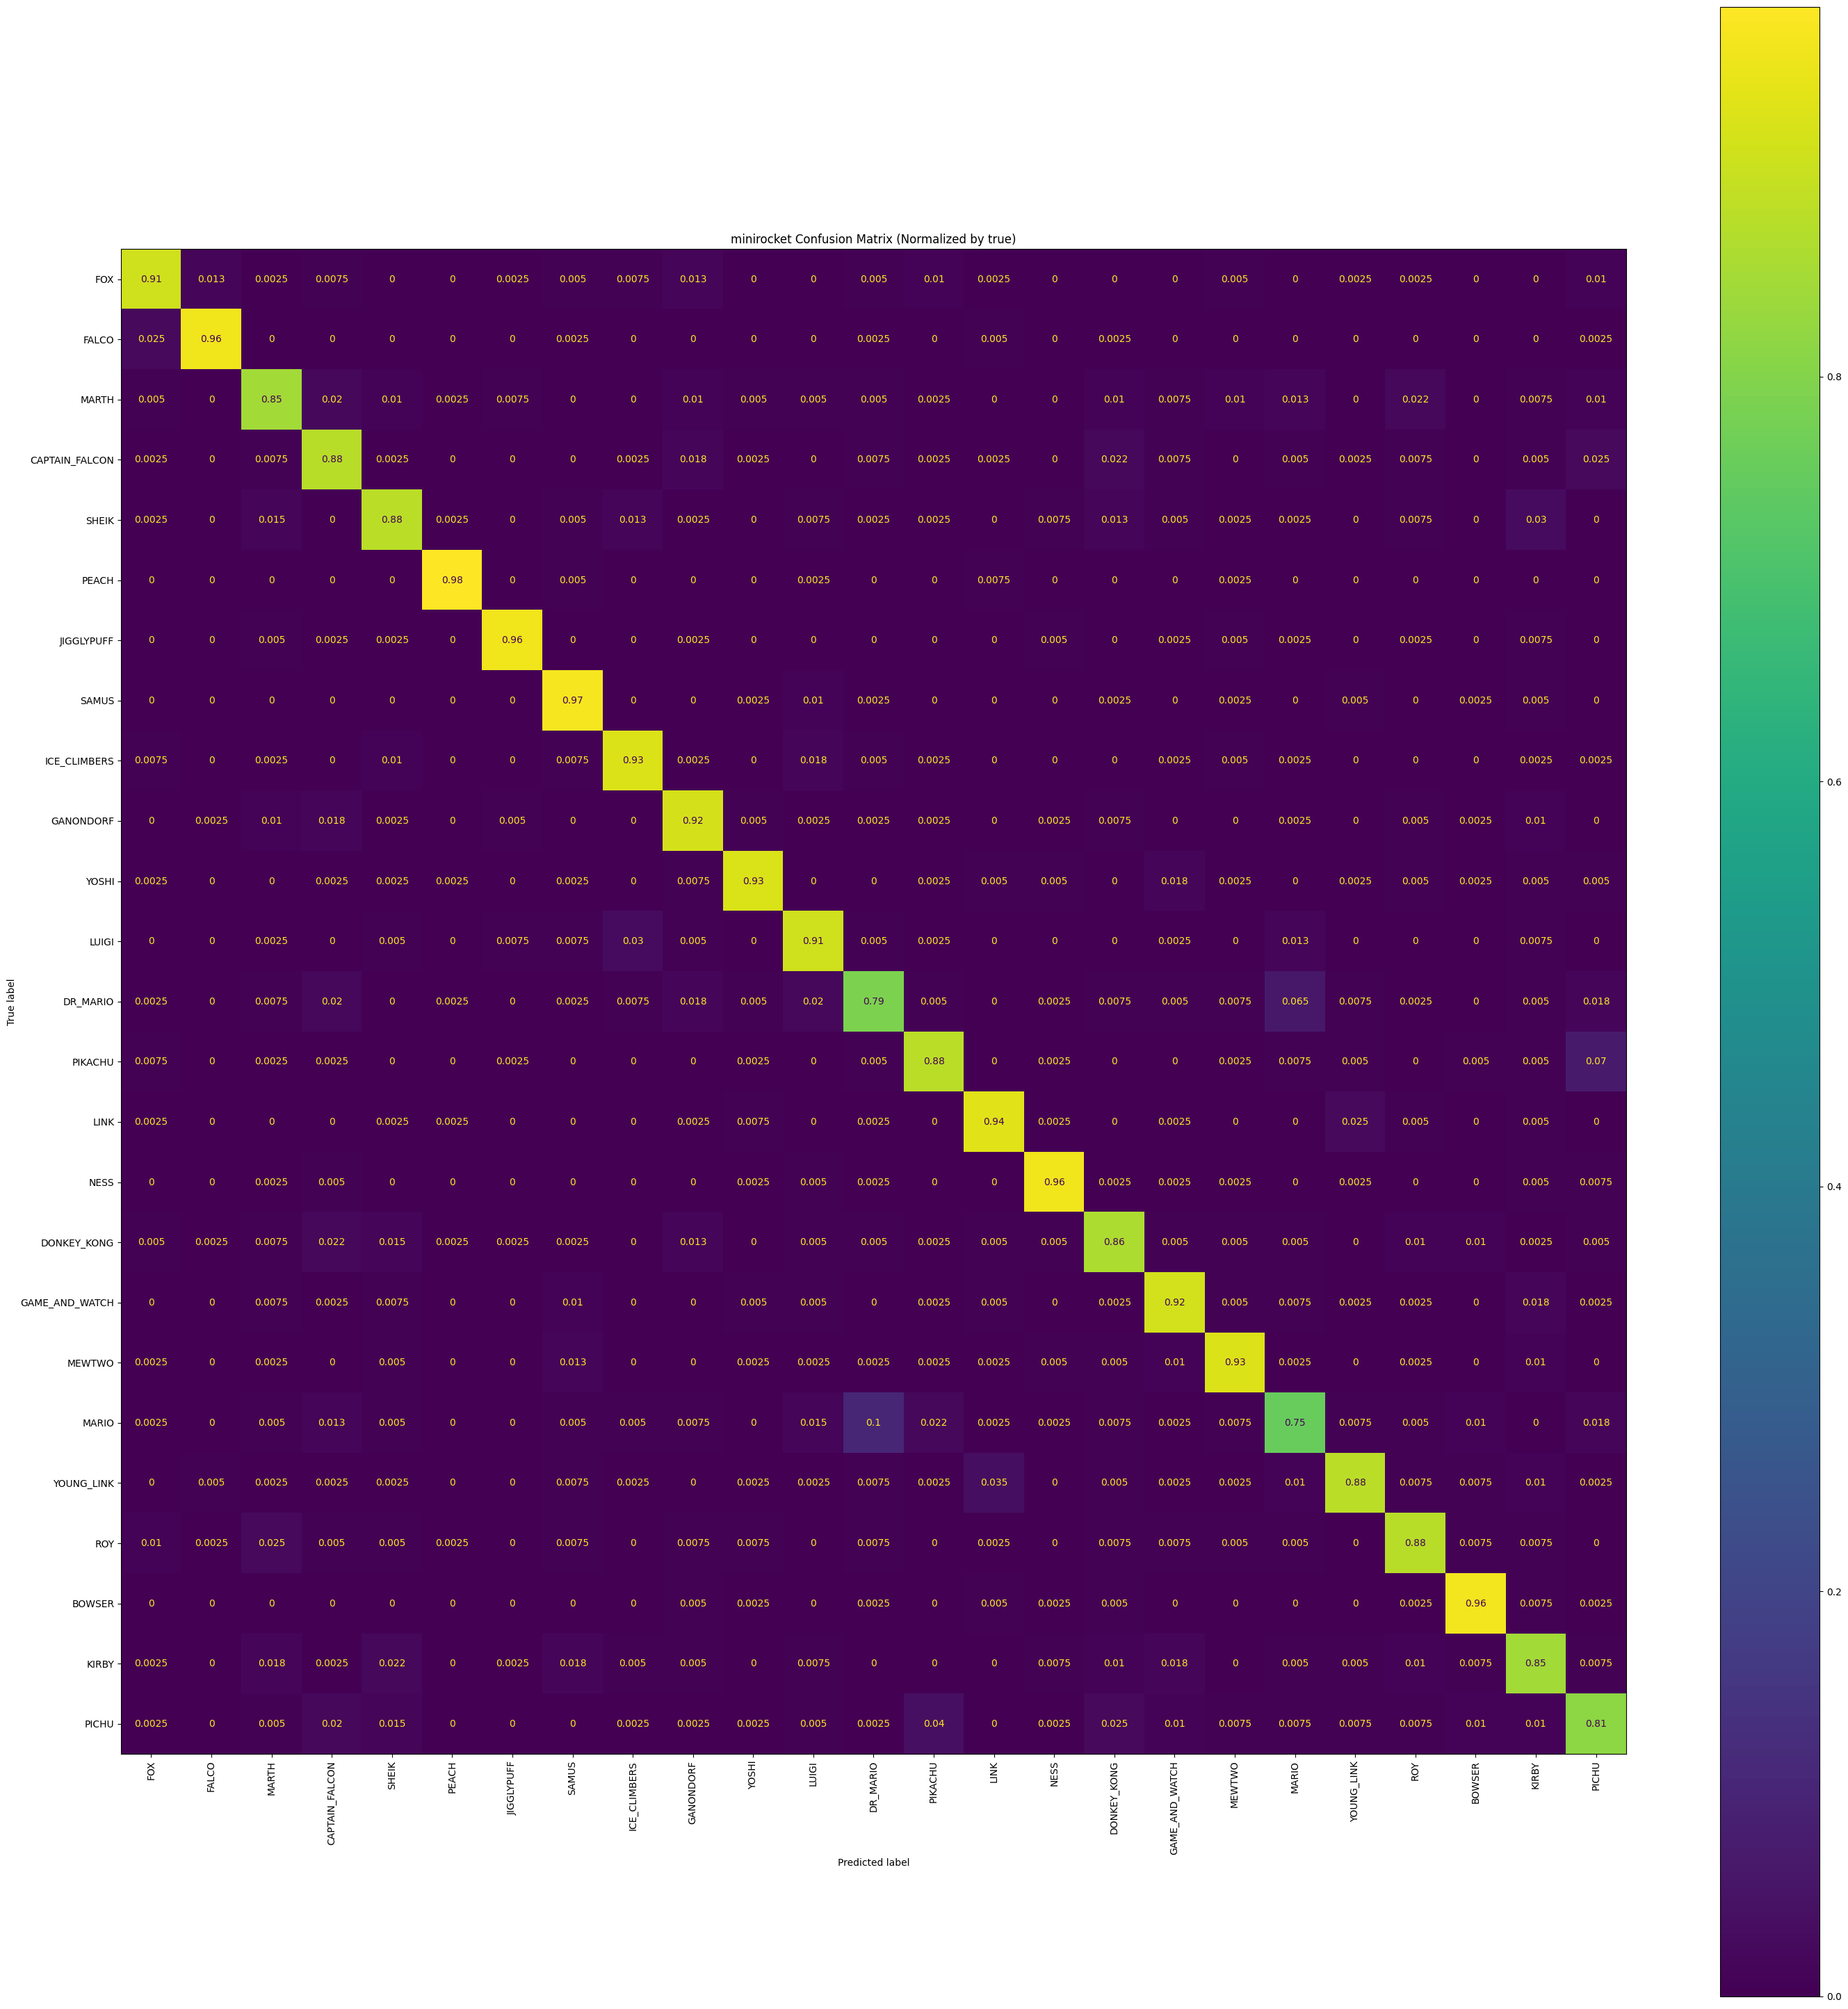

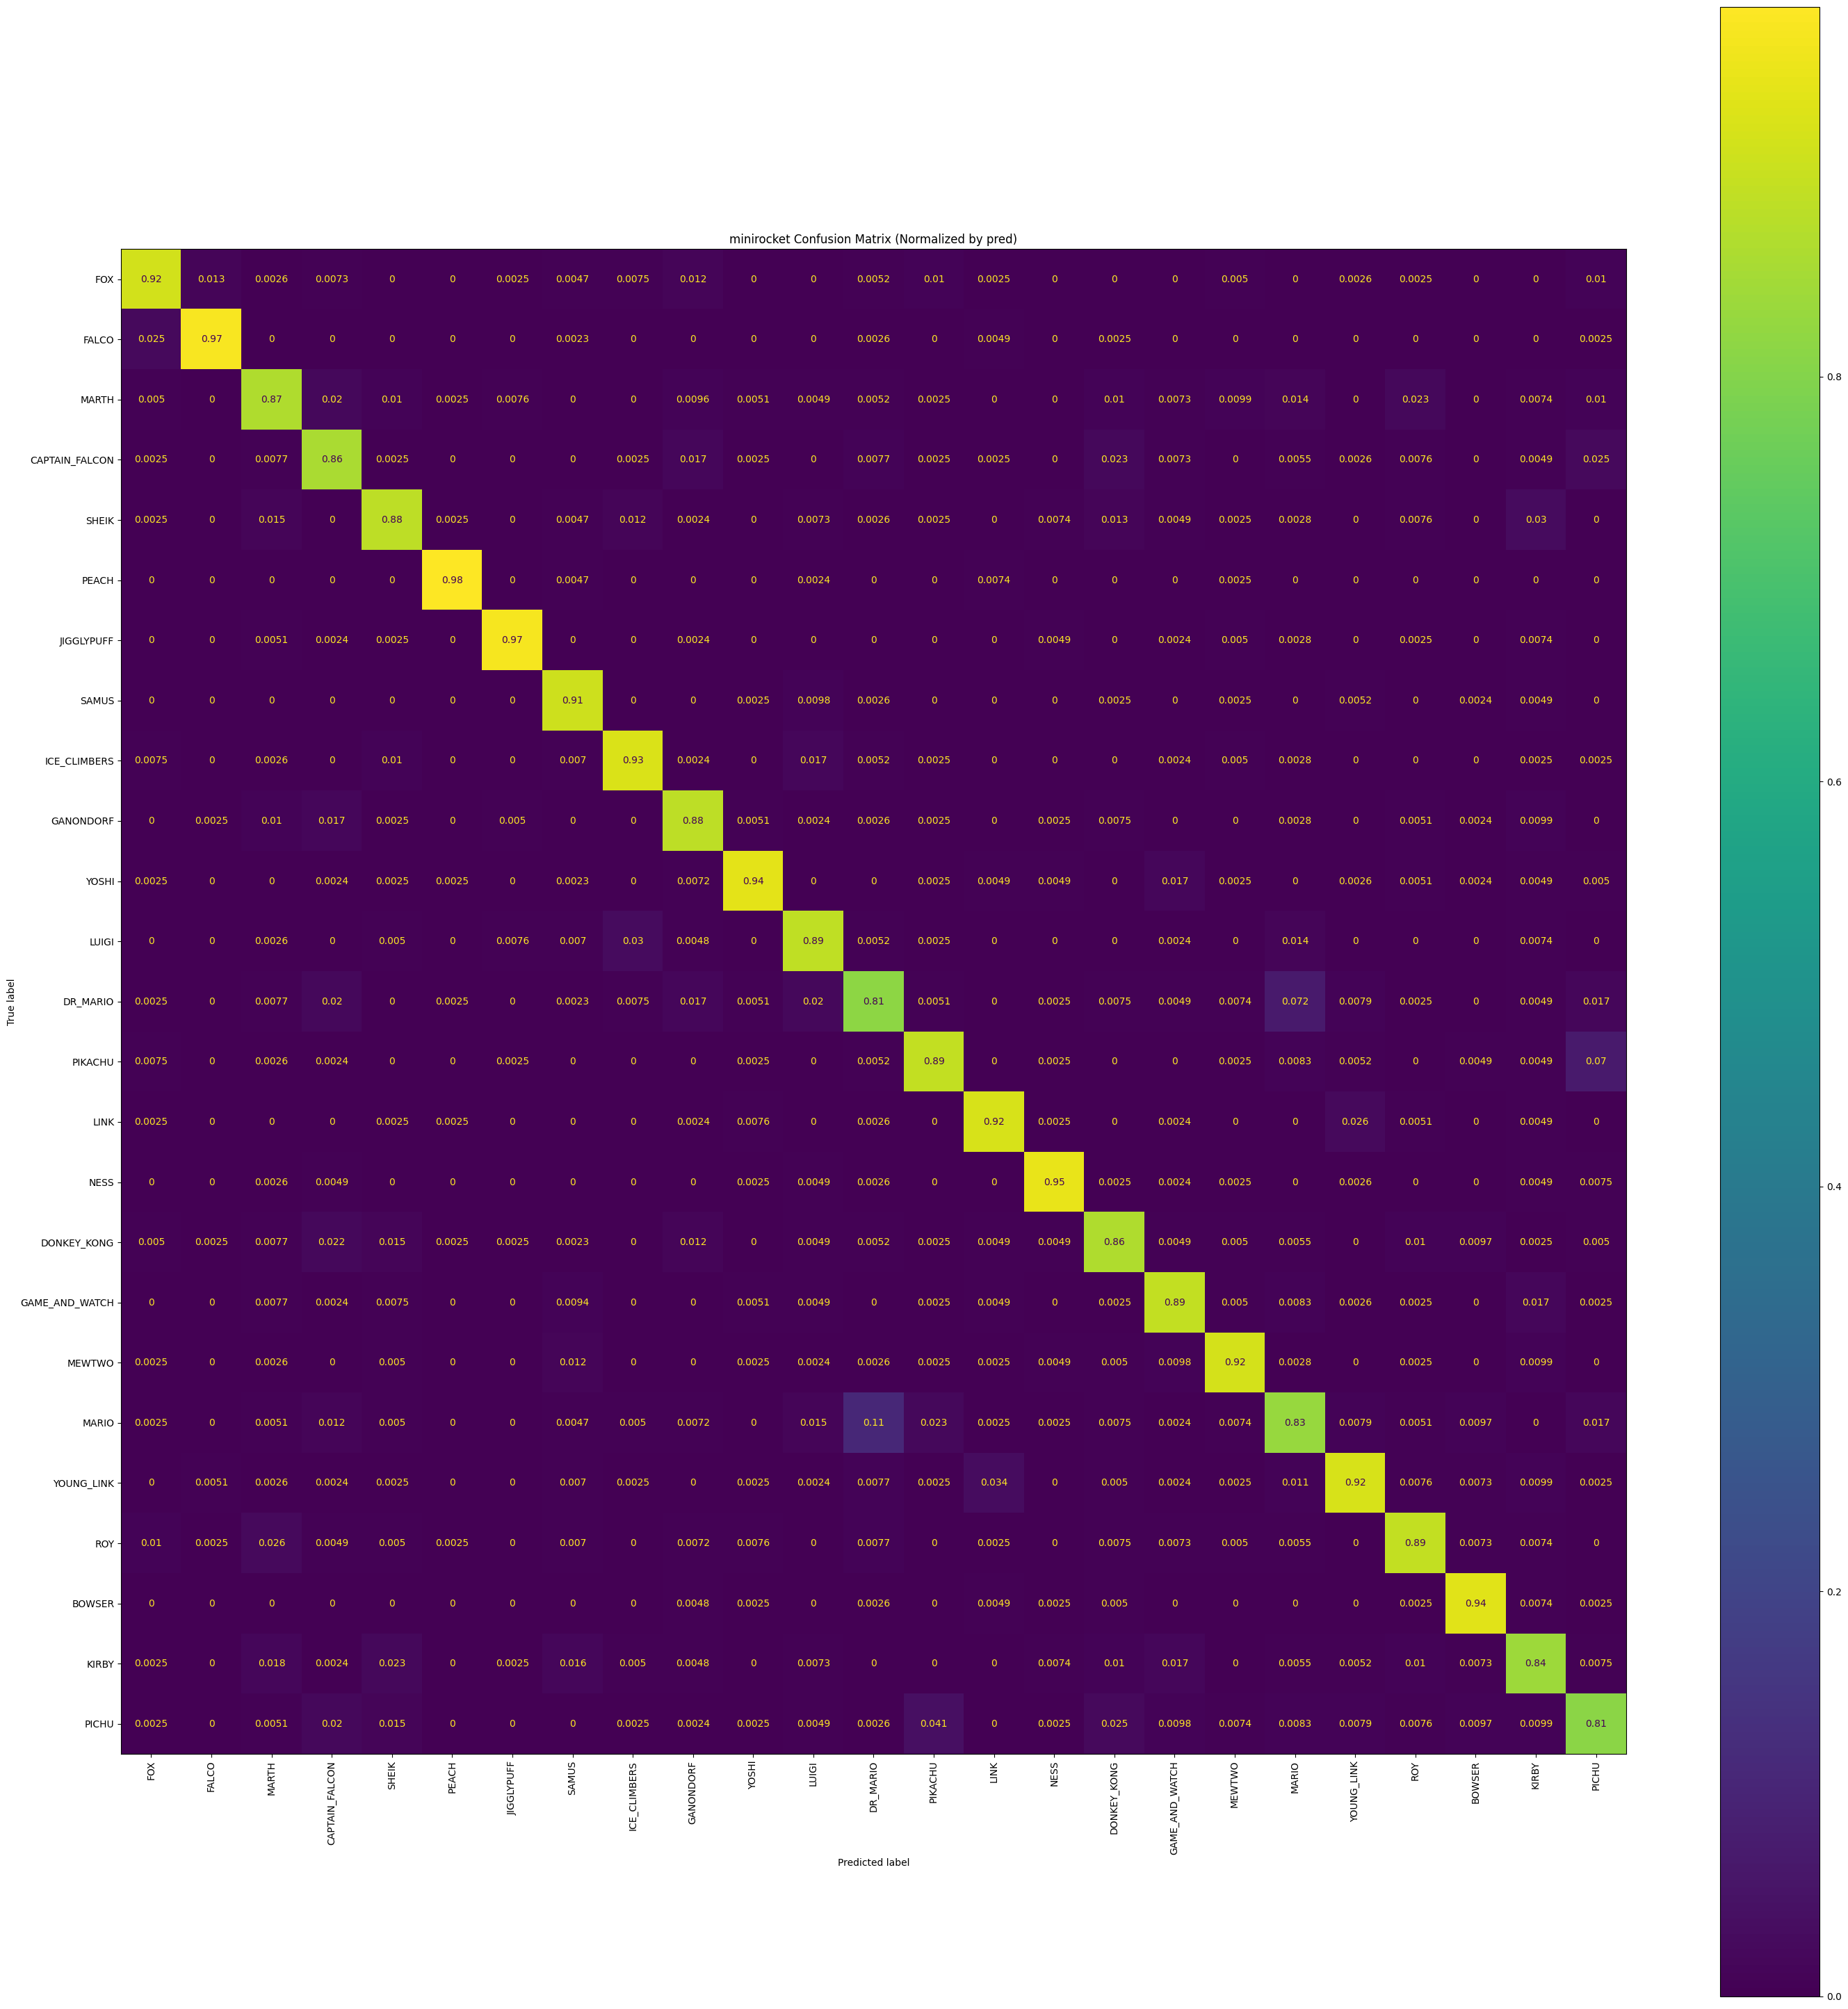

In [ ]:
asses_model('minirocket', y_pred, y_test, labels_order)